In [2]:
# bundle exec jekyll serve
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
sns.set()

### Motivation
Dataset

The study is about street trees. Multiple datasets has been used to investigate the street trees in copenhagen and the regions they are planted
The main dataset is about street trees in copenhagen from 1750-2023. It involves which types of tree, when and where they were planted, together with detailed information about who payed, how it was planted and its botanic value. 
The other dataset contains different information about the regions of Copenhagen. From this I have used the population size and the region area. 

Reason for choosing datasets

These datasets are seems to be the best for the task. The street tree dataset is very big and contains many observations and features, and seems to be unique. The other data is information that is not difficult to get elsewhere, but dataset was chosen because it is from "Danmarks Statestik" which makes it more trustable. 

Goal

Trees are important for cities and the people around them. This study investigates where and which trees are planted compared to area, population size and income of region, to show that copenhagen favors certain parts of the city, and answer why this might to right or wrong.  

In [3]:
# Load street tree dataset 
data_ori = pd.read_csv('./Assignment final/gadetraer.csv')
data_ori['bydelsnavn'][data_ori['bydelsnavn']=='Vesterbro-Kongens Enghave'] = 'Vesterbro'
# Load copenhagen statistics dataset 
population = [80605, 86668, 56446, 78583, 79646, 66435, 62197, 43933, 40633, 54346]#[86668, 62197, 54346, 43933, 56446, 78583, 66435, 40633, 79646, 80605]
area = [9.854, 19.36, 9.416, 4.104, 8.355, 9.232, 9.779, 8.738, 6.697, 6.828]#[19.36,  9.779, 6.828, 8.738, 9.416, 4.104, 9.232, 6.697, 8.355, 9.854]

/tmp/ipykernel_4103/681729936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ori['bydelsnavn'][data_ori['bydelsnavn']=='Vesterbro-Kongens Enghave'] = 'Vesterbro'


In [4]:
# View variables
print(data_ori.columns)

Index(['FID', 'id', 'traeart', 'slaegt', 'dansk_navn', 'slaegtsnavn',
       'planteaar', 'plantet_halvaar', 'garantiperioden_udloeber',
       'plantemetode', 'ejer', 'driftsorganisation', 'driftsplan_navn',
       'driftsaftale_edoc_nr', 'bemaerkning', 'andre_vaekstforhold',
       'fredet_beskyttet_trae', 'fredning_edoc_nr', 'trae_historie',
       'botanisk_interesse', 'donor', 'anledning', 'saerligt_trae',
       'saerlig_trae_bem', 'bydelsnavn', 'fredet_trae_foto', 'vejstatus',
       'ogc_fid', 'wkb_geometry'],
      dtype='object')


### Basic stats
Preprocessing

The dataset contains many variables but many contains mostly NaNs. This analysis only makes use of a few variables and all these are therefore removed. 
The dataset contains a few observations of trees planted in 1750, which are rare and left out to avoid any misleading results. All observations before 1920 is thus deselected since the values are not consistent and are also very few. The year 2023 is also removed due to it being incomplete and therefore misleading for any analysis. It is still not every year that has an observation, one one should be aware of when making plots of the development over the years.

In this analysis we only make use of the attributes "slaegtsnavn" (tree sort), "planteaar" (year) and "bydelsnavn" (region). None of these contains any missing values.

In [5]:
data = data_ori[['slaegtsnavn', 'planteaar', 'bydelsnavn']][(data_ori['planteaar']>=1920) & (data_ori['planteaar']<2023)]
data.head()

,slaegtsnavn,planteaar,bydelsnavn
0,Lind,1931.0,Vesterbro
1,Lind,1931.0,Vesterbro
2,Lind,1931.0,Vesterbro
3,Lind,2021.0,Vesterbro
4,Lind,1931.0,Vesterbro


dataset stats

In [6]:
def get(x):
    X, X_count = np.unique(data[x], return_counts=True)
    sortidx = np.argsort(X_count)[::-1]
    return X[sortidx], X_count[sortidx]
species, species_count = get('slaegtsnavn')
regions, regions_count = get('bydelsnavn')
year, year_count = get('planteaar')


In [16]:
print(f"""After preprocessing the dataset contains {len(data)} observations, with {data.shape[1]} variables.
Each observation has a year and a region attribute. It involves all {len(regions)} regions of Copenhagen: {regions}.
There are in all {len(species)} different species, and the three most common species are {species[:3]} with respectively {species_count[:3]} plantings.
The regions with most planted tree is {regions[0]} with {regions_count[0]} plantings, {area[0]} km² and {population[0]} citizens""")

After preprocessing the dataset contains 18921 observations, with 3 variables.
Each observation has a year and a region attribute. It involves all 10 regions of Copenhagen: ['Østerbro' 'Amager Vest' 'Indre By' 'Nørrebro' 'Vesterbro' 'Valby'
 'Amager Øst' 'Brønshøj-Husum' 'Vanløse' 'Bispebjerg'].
There are in all 55 different species, and the three most common species are ['Lind' 'Platan' 'Røn'] with respectively [4510 2152 1915] plantings.
The regions with most planted tree is Østerbro with 3433 plantings, 9.854 km² and 80605 citizens


The plots below gives the main results, the plots are mentioned in the order they are shown below. 3), 4) and 5) are not used in the study, but shows general dataset statistics

1) Shows the development of planted trees from 1920 to 2022, both in total number of trees and number of different species. 
This plot shows that Copenhagen have been planting much more trees the last years, and that it has been focusing on diversity.

2) A combined barchart showing the ratio between number of planted trees (between 1920-2022) and area and population size of each part of the city. 
This plot shows that some parts of copenhagen are favored above other parts. The number of planted trees should be much more correlated with the area or the population of the region, this is not the case.

3) Number of species planted in each region

4) Number of total trees planted in each region

5) Number of planted tree for each species 

6) Stacked area plot of the development of each species from 1920 to 2022 in all of Copenhagen

7) Stacked area plot of the development of each species from 1920 to 2022 in each region of Copenhagen

In [17]:
# Define plotting functions
def plot(X, labs, title, ylab, bar=True, xstep=1, save_path=None):
    fig, ax = plt.subplots(dpi=70)
    axes = [ax, ax.twinx()] if len(X)>1 else [ax]
    plt.title(title, size=14)
    y_pos = np.arange(len(X[0]))
    width = 0.75/len(X)
    for i in range(len(X)):
        if bar: axes[i].bar(y_pos+i*width, X[i], width, color=f'C{i}')
        else: axes[i].plot(y_pos, gaussian_filter1d(X[i], 1), color=f'C{i}')
        axes[i].set_ylim(0)
        axes[i].set_ylabel(ylab[i], color=(f'C{i}' if len(X)>1 else 'k'), size=14)
        axes[i].set_xticks(y_pos[::xstep], labs[::xstep], rotation=40)
    if len(X)>1: 
        axes[1].set_yticks(np.linspace(axes[1].get_yticks()[0], axes[1].get_yticks()[-1], len(axes[0].get_yticks())))
        axes[0].set_yticks(np.linspace(axes[0].get_yticks()[0], axes[0].get_yticks()[-1], len(axes[0].get_yticks())))
        axes[1].grid(None)
    if not save_path is None:
        plt.savefig('./public/'+save_path+'.png', dpi=200)

def barch(x, title, ylab, xx=None, cutoffx=None, bar=True, xstep=1,save_path=None):
    '''Some preprocessing similar for all methods, before calling "plot"'''
    # Get data
    labs, X1, = np.unique(data[x], return_counts=True)
    if not xx is None: X2 = np.array([len(np.unique(data[xx][data[x]==i])) for i in labs])
    # Remove values related to counts
    if not cutoffx is None: 
        sel = X1 > cutoffx
        labs = labs[sel]; X1 = X1[sel]
    # Specific for year, there are a few missing values, fill out with zeros
    if x=='planteaar':
        labs_new = np.arange(1920,2023)
        sel = np.isin(labs_new, labs)
        X1_new = np.zeros(len(sel)); X2_new = np.zeros(len(sel))
        X1_new[sel] = X1; X2_new[sel] = X2
        X1 = X1_new; X2 = X2_new; labs = labs_new
    # plot
    if isinstance(ylab, str): 
        ylab = [ylab]
        X = [X1] if xx is None else [X2]
    else: 
        X = [X1,X2]
    plot(X, labs, title, ylab, bar, xstep, save_path)


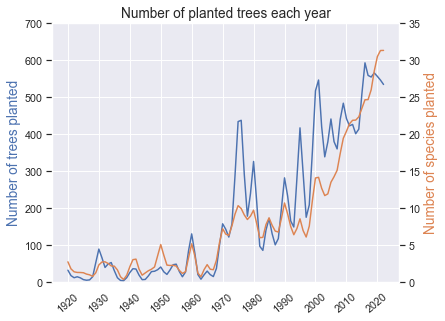

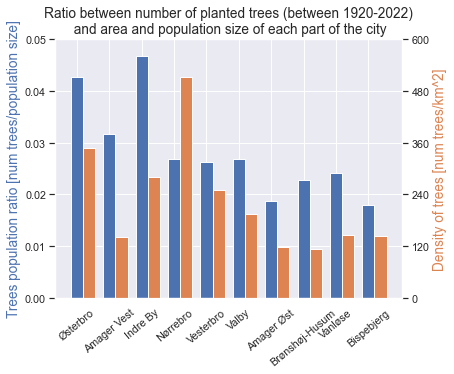

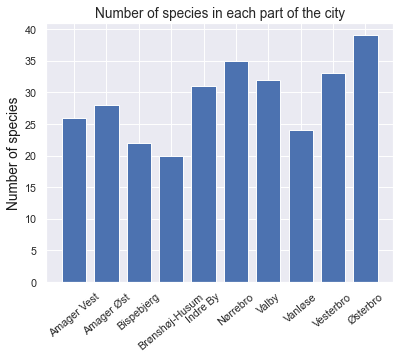

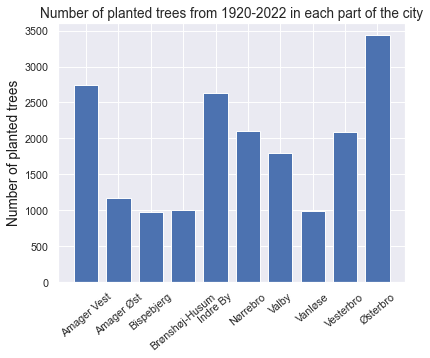

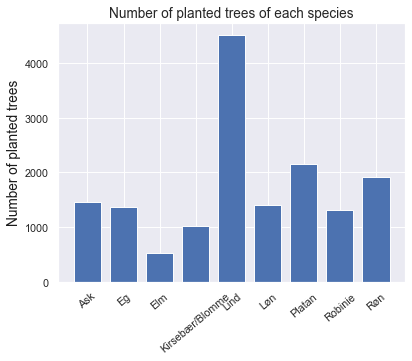

In [18]:
# Make plots
barch('planteaar', 
      title = 'Number of planted trees each year',
      ylab = ['Number of trees planted','Number of species planted'],
      xx = 'slaegtsnavn', 
      bar=False, xstep=10,
      save_path = 'tree_amount_tree_diversity')

plot((regions_count/population, regions_count/area), 
     regions, 
     ylab = ['Trees population ratio [num trees/population size]', 'Density of trees [num trees/km^2]'], 
     title = 'Ratio between number of planted trees (between 1920-2022)\n and area and population size of each part of the city',
     save_path = 'tree_density_tree_population_ratio')

barch('bydelsnavn', 
      title = 'Number of species in each part of the city', 
      ylab = 'Number of species',
      xx = 'slaegtsnavn')


barch('bydelsnavn', 
      title = 'Number of planted trees from 1920-2022 in each part of the city', 
      ylab = 'Number of planted trees')


barch('slaegtsnavn', 
      title = 'Number of planted trees of each species', 
      ylab = 'Number of planted trees', 
      cutoffx=500)


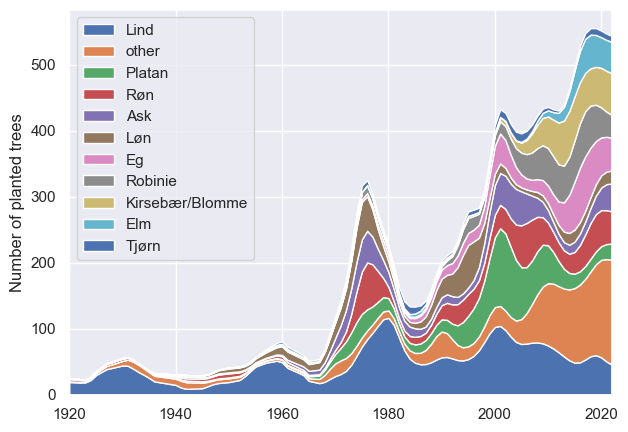

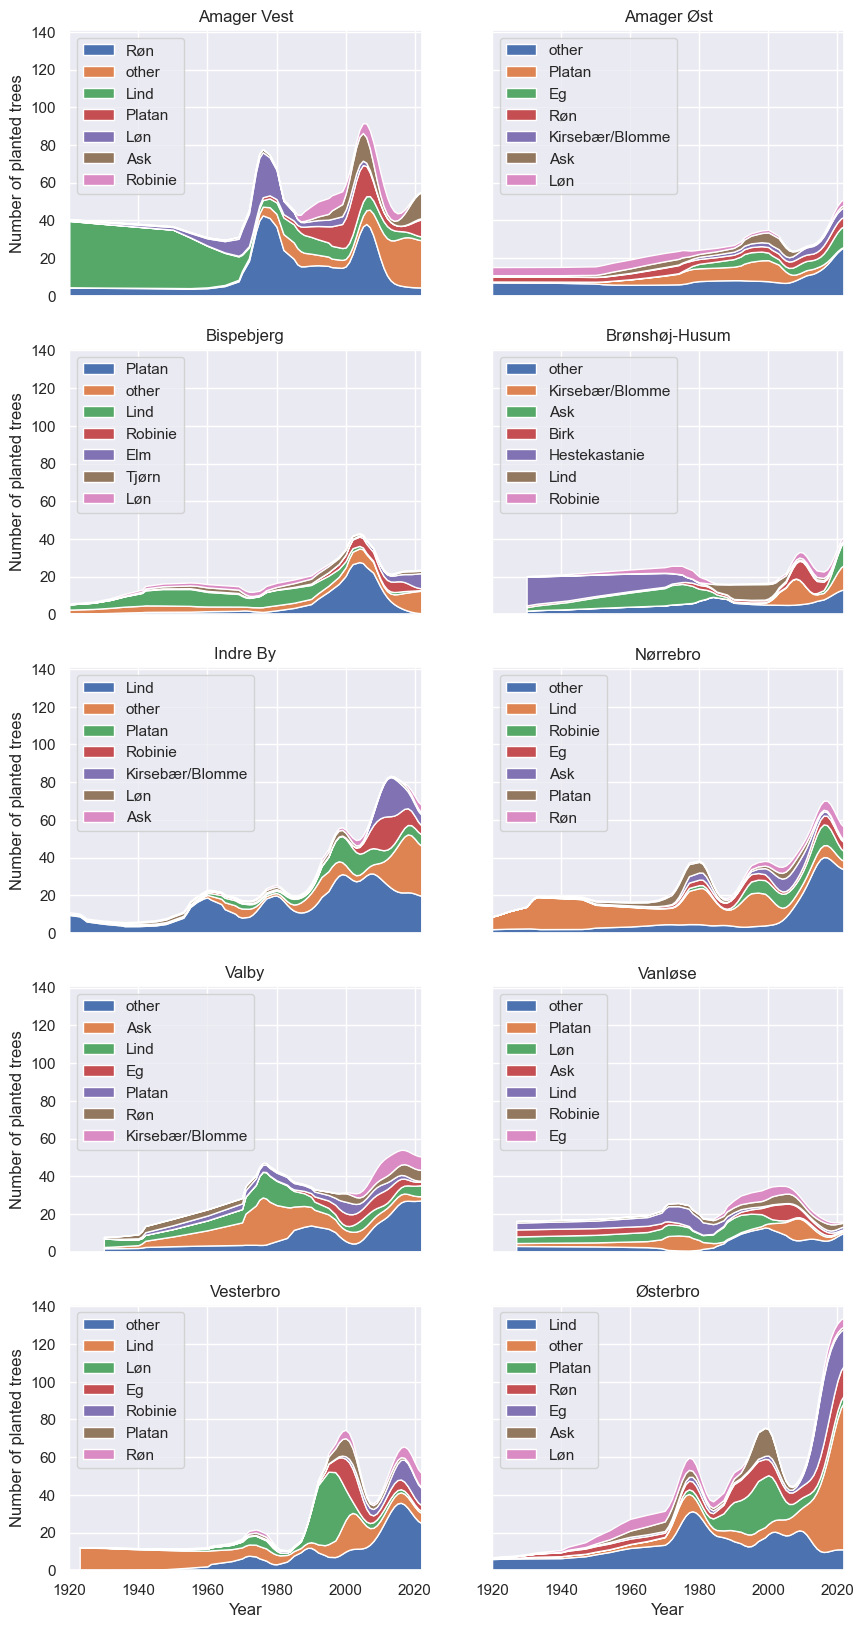

In [70]:
# Data
def stacked_plot(num_spe, shape, save_path=None, smoothing=3):
    datat = data['bydelsnavn']
    single = np.prod(shape)==1
    fig, axes = plt.subplots(*shape, dpi = 100, sharex=True, sharey=True, figsize=(10,20) if not single else (7,5))
    for k, region in enumerate(regions):
        if single:
            ax = axes
        else:
            ax = axes[k//2, k%2]
            ax.set_title(region)
        ax.set_xlim((1920,2022))
        if not k%2: ax.set_ylabel('Number of planted trees')
        if k==9 or k==8: ax.set_xlabel('Year')

        datay = data['planteaar']
        datas = data['slaegtsnavn']
        if not single:
            datay = datay[datat == region]
            datas = datas[datat == region]

        years = np.unique(datay)
        species, X = np.unique(datas, return_counts=True)
        sel = np.argsort(X)[::-1][:num_spe]
        other_amount = sum(X) - sum(X[sel])
        labels_sel = np.insert(species[sel], sum(other_amount < X[sel]),'other')

        ys = np.zeros((len(labels_sel), len(years)))
        for n, y in enumerate(years):
            nam, val = np.unique(datas[datay==y], return_counts=True)
            for name,v in zip(nam,val):
                ys[name==labels_sel, n] = v
            ys['other'==labels_sel, n] = sum(val) - np.sum(ys[:,n])
        # Plot
        ys = gaussian_filter1d(ys, smoothing)
        ax.stackplot(years,ys, labels=labels_sel)
        ax.legend(loc='upper left')
        if single: break
        
    if not save_path is None:
        plt.savefig('./public/'+save_path+'.png', dpi=200)

# Check something does not add up with the others look at the first plot
stacked_plot(10, shape=(1,1), save_path='stacked_copenhagen', smoothing=2)
stacked_plot( 6, shape=(5,2), save_path='stacked_regions')


### Data Analysis
The dataset shows that Copenhagen have been planting a lot of trees in the last years expecically after 2000. The goal have not simply be to plant a lot og trees but it has also been about focusing on diversity, which have been increasing in same rate as the total number of planted trees. The data also reveals a uneven distribution of trees, most often the area or population is correlated with the number of planted trees, but for the two regions with highest income have a much higher ratio of tree per citizen and density of trees.

### Genre
Tools used from each of the 3 categories of Visual Narrative

Visual Narrative tactics are visual tactics used to guide the viewer through the narrative.

1) Visual structuring: Allows viewer to locate oneself respect to the whole visualization (establishing shot, checklist, consistent visual platform, progress bar, timeline slider).

For a website this small a visual structuring would often not be necessary. On this website no visual structing was used except from the default "progress bar" to the right of the screen.

2) Highlighting: Draws the viewers attention to a certain part of the visualization (color, motion, framing, size, audio).

Highlighting was used in a high degree. It was used to color the titles green in a matching color to the the blue green-ish header of the website. The website uses a lot pf plots that draws attention with a wide range of colors, that stand out from the text.

3) Transition guidance: Makes visual transitions comprehensive.

Visual transitions in this study only includes scrolling down the webpage, which is a continues transition that is easy to keep track of. There is no need for anything more on a webpage like this.

Tools used from each of the 3 categories of Narrative Structure

Narrative Structure tactics are both visual and non-visual tactics to guide the viewer through the narrative. 

1) Ordering: The path through the visualization

The path through this visualization is linear. This gives the best and most understandable effect for the story told.

2) Interactivity: Manipulation of the visualizations (filtering, selecting, searching, navigating, explicit instruction, tacit tutorial, initial configuration).

No figures are interactive in this study, and thus no tools from this category was used.

3) Messaging: How visualizations gets the message across (labels, captions, headlines, annotations, articles, introductions, summaries)

All figures have headlines and captions to indicate what they show. 


### Visualizations

Visualizations

Stacked area plot:
It is very clear that planting of trees comes in project, in a few year a very large amount of trees where planted while other years almost none trees where planted. In order to make a stacked area plot, a smoothing was nessecary, in this case a simple gaussian filter was used to even out the peaks in the plot. 

Why are they right



### Discussion


What went well?


Improvements



### Contributions
I didely done it all